Group Members: Dhruv Baid, Prajakta Phadke, Uday Sharma

# Install External Modules {-}

In [1]:
# !pip install finbert-embedding
# !pip install gensim
# !pip install hmmlearn
# !pip install numpy==1.21.4
# !pip install pandas==1.5.1
# !pip install pyldavis
# !pip install seaborn
# !pip install torch torchvision torchaudio
# !pip install transformers
# !pip install yahoofinance

# Imports/Settings {-}

## Macro Variables

In [2]:
# Set LDA_IMPORT flag to True only if you have the correct version of Pandas installed!
LDA_IMPORT = False

## Import External Modules

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from datetime import datetime
from finbert_embedding.embedding import FinbertEmbedding
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
import numpy as np
import os
import pandas as pd
if LDA_IMPORT:
    import pyLDAvis
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import sys

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhruv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import Internal Modules

In [5]:
sys.path.append(os.getcwd() + '/modules')
from modules.cross_validation import Pipeline, CustomCrossValidation
from modules.data import *
from modules.directional_change import *
from modules.hidden_markov_model import make_regime_plots, fit_hmm
from modules.kmeans import *
from modules.logistic_regression import do_all_LR
from modules.NaiveBayesClassifier import *
from modules.svm import do_all_SVM
from modules.text_preprocessing import *
from modules.topic_modeling import *
from modules.trading_strategy import *
from modules.visualization import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhruv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
plt.style.use('seaborn')
sns.set_theme()

# Assign Train/Test Dates {-}

In [7]:
period_start = datetime(1985, 1, 1)
period_end = datetime(2023, 6, 30)

train_start = datetime(1985, 1, 1)
train_end = datetime(2019, 12, 31)
test_start = datetime(2020, 1, 1)
test_end = datetime(2023, 6, 30)

# Unsupervised Learning {-}

## Natural Language Processing {-}

### Text Data - Reading {-}

In [8]:
FOMC_FPATH = '../fomc_documents/fomc_documents.csv'
# FOMC_PATH = 'data/fomc_documents.csv'

In [9]:
fomc_data = get_text_data(fpath=FOMC_FPATH)
fomc_data

,document_kind,meeting_date,release_date,text,url
2947,minutes_of_actions,1985-02-13,1985-03-15,Meeting of the Federal Open Market Committee F...,https://www.federalreserve.gov/monetarypolicy/...
2960,minutes_of_actions,1985-03-26,1985-04-25,Meeting of the Federal Open Market Committee M...,https://www.federalreserve.gov/monetarypolicy/...
2968,minutes_of_actions,1985-05-21,1985-06-20,Meeting of the Federal Open Market Committee M...,https://www.federalreserve.gov/monetarypolicy/...
2982,minutes_of_actions,1985-07-10,1985-08-09,Meeting of the Federal Open Market Committee J...,https://www.federalreserve.gov/monetarypolicy/...
2992,minutes_of_actions,1985-08-20,1985-09-19,Meeting of the Federal Open Market Committee A...,https://www.federalreserve.gov/monetarypolicy/...
...,...,...,...,...,...
5933,minutes,2022-12-14,2023-01-04,Minutes of the Federal Open Market Committee D...,https://www.federalreserve.gov/monetarypolicy/...
5936,minutes,2023-02-01,2023-02-22,Minutes of the Federal Open Market Committee J...,https://www.federalreserve.gov/monetarypolicy/...
5940,minutes,2023-03-22,2023-04-12,Minutes of the Federal Open Market Committee M...,https://www.federalreserve.gov/monetarypolicy/...
5946,minutes,2023-05-03,2023-05-24,Minutes of the Federal Open Market Committee M...,https://www.federalreserve.gov/monetarypolicy/...


### Text Data - Pre-Processing {-}

In [10]:
# Remove names
fomc_data.text = fomc_data.text.apply(remove_names_from_minutes)

# Remove stop-words
fomc_data.text = fomc_data.text.apply(tokenizer_wo_stopwords)

# Set index as meeting_date
fomc_data.set_index('meeting_date', inplace=True)

fomc_data

,document_kind,release_date,text,url
meeting_date,,,,
1985-02-13,minutes_of_actions,1985-03-15,vote gerald corrigan elected serve vice chairm...,https://www.federalreserve.gov/monetarypolicy/...
1985-03-26,minutes_of_actions,1985-04-25,vote following officers open market elected se...,https://www.federalreserve.gov/monetarypolicy/...
1985-05-21,minutes_of_actions,1985-06-20,vote actions taken open market held march appr...,https://www.federalreserve.gov/monetarypolicy/...
1985-07-10,minutes_of_actions,1985-08-09,vote actions taken open market held approved,https://www.federalreserve.gov/monetarypolicy/...
1985-08-20,minutes_of_actions,1985-09-19,vote actions taken open market held july approved,https://www.federalreserve.gov/monetarypolicy/...
...,...,...,...,...
2022-12-14,minutes,2023-01-04,vote selected richard ostrander serve deputy g...,https://www.federalreserve.gov/monetarypolicy/...
2023-02-01,minutes,2023-02-22,vote following officers selected serve selecti...,https://www.federalreserve.gov/monetarypolicy/...
2023-03-22,minutes,2023-04-12,turned review financial market developments in...,https://www.federalreserve.gov/monetarypolicy/...


In [11]:
# Define train and test data
train_data = fomc_data[(fomc_data.index >= train_start) & (fomc_data.index <= train_end)]
test_data = fomc_data[(fomc_data.index >= test_start) & (fomc_data.index <= test_end)]

### Label Generation {-}

#### TF-IDF Values Computation {-}

In [12]:
# Compute TF-IDF values
tfidf_class = TF_IDF(X_train=train_data.text, X_test=test_data.text)

tfidf_class.fit_manual()
tfidf_class.fit_gensim()

#### K-Means Clustering on TF-IDF Values {-}

In [13]:
# Train KMeans Clustering
model_kmeans = KMeansCluster(
    k=2,
    X_train=preprocessing.normalize(tfidf_class.tfidf_gensim_train),
    X_test=preprocessing.normalize(tfidf_class.tfidf_gensim_test),
)
model_kmeans.fit()
model_kmeans.predict()

In [14]:
display(pd.merge(
    left=model_kmeans.sizes_train_df,
    right=model_kmeans.sizes_test_df,
    left_index=True,
    right_index=True,
    suffixes=('_TRAIN', '_TEST'),
)['CLUSTER_SIZE_TRAIN'])

CLUSTER
0    177
1    104
Name: CLUSTER_SIZE_TRAIN, dtype: int32

In [15]:
assert model_kmeans.labels_.shape[0] == train_data.shape[0]
assert model_kmeans.y_test_pred.shape[0] == test_data.shape[0]

nlp_regimes_train = pd.DataFrame.from_dict({
    'NLP_Regimes': model_kmeans.labels_
}).set_index(train_data.index)
nlp_regimes_test = pd.DataFrame.from_dict({
    'NLP_Regimes': model_kmeans.y_test_pred
}).set_index(pd.to_datetime(test_data.index))

display(nlp_regimes_train)
# display(nlp_regimes_test)

,NLP_Regimes
meeting_date,
1985-02-13,1
1985-03-26,1
1985-05-21,1
1985-07-10,1
1985-08-20,1
...,...
2019-06-19,0
2019-07-31,0
2019-09-18,0


#### Wordclouds using Training Labels {-}

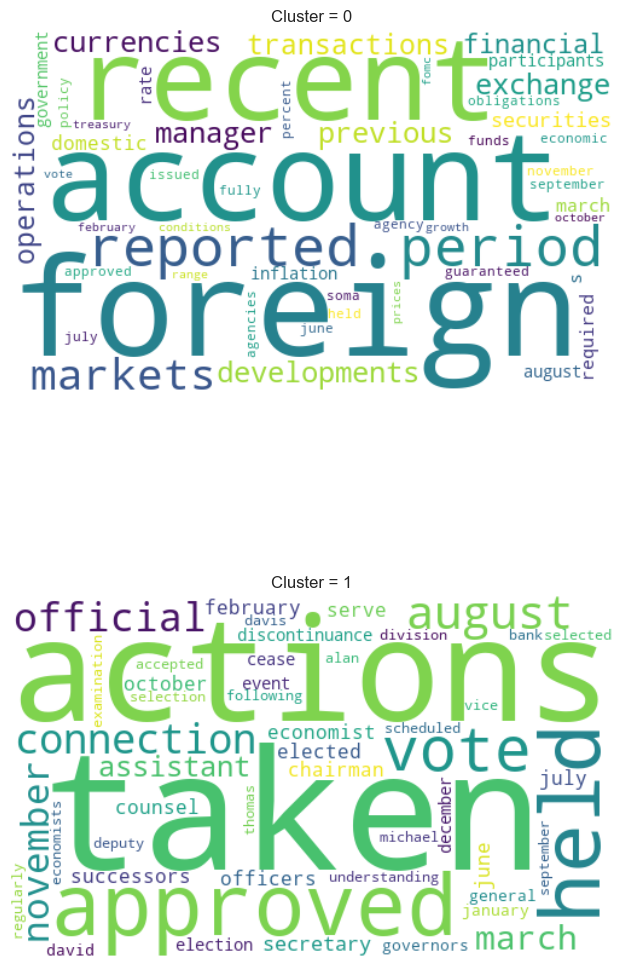

In [16]:
wordcloud_clusters(
    model_kmeans.model,
    preprocessing.normalize(tfidf_class.tfidf_gensim_train),
    tfidf_class.dict_gensim_statements,
)

### Feature Generation {-}

#### Topic Modeling (CV Scoring) {-}

In [17]:
X_test = tfidf_class.X_test.apply(tokenizer_wo_stopwords).apply(lambda x: x.split(" "))
bow_test = [tfidf_class.dict_gensim_statements.doc2bow(text) for text in X_test]

topicmod = TopicModel(
    tfidf_class.tfidf_statements_train,
    tfidf_class.dict_gensim_statements,
    tfidf_class.X_train.apply(tokenizer_wo_stopwords).apply(lambda x: x.split(" ")).tolist(),
    bow_test,
)

topicmod.fit_predict()

In [18]:
topicmod.num_topic

10

In [19]:
topicmod.cv_topics_list

[(10, 0.4962291321541573),
 (5, 0.48200517385359387),
 (7, 0.45150784480669054),
 (2, 0.3560655730463756)]

In [20]:
# pdf_test = topicmod.pdf_test
print(topicmod.pdf_test.shape)

(28, 10)


In [21]:
topic_models_train = pd.DataFrame(
    topicmod.doc_mat,
    columns=[f"Topic_{i}" for i in range(10)],
    index=tfidf_class.X_train.index
)

topic_models_test = pd.DataFrame(
    topicmod.pdf_test,
    columns=[f"Topic_{i}" for i in range(10)],
    index=tfidf_class.X_test.index
)

##### Top 10 Words by Topic

In [22]:
print("Top 10 words for topics")
topicmod.cv_model.show_topics(num_words=10)

Top 10 words for topics


[(0,
  '0.031*"june" + 0.011*"inflation" + 0.009*"economic" + 0.009*"labor" + 0.008*"policy" + 0.007*"pace" + 0.007*"conditions" + 0.006*"participants" + 0.006*"growth" + 0.006*"quarter"'),
 (1,
  '0.067*"august" + 0.036*"september" + 0.018*"april" + 0.013*"s" + 0.009*"inflation" + 0.009*"participants" + 0.008*"business" + 0.008*"selection" + 0.008*"agency" + 0.007*"obligations"'),
 (2,
  '0.027*"participants" + 0.021*"projections" + 0.018*"financial" + 0.017*"rate" + 0.017*"percent" + 0.016*"inflation" + 0.014*"domestic" + 0.011*"october" + 0.010*"appropriate" + 0.009*"unemployment"'),
 (3,
  '0.089*"taken" + 0.081*"actions" + 0.064*"march" + 0.057*"february" + 0.056*"approved" + 0.052*"held" + 0.033*"vote" + 0.021*"chairman" + 0.018*"required" + 0.016*"august"'),
 (4,
  '0.014*"deputy" + 0.011*"secretary" + 0.011*"assistant" + 0.011*"counsel" + 0.010*"economist" + 0.010*"rate" + 0.009*"general" + 0.009*"rates" + 0.008*"continued" + 0.008*"policy"'),
 (5,
  '0.018*"soma" + 0.013*"infl

##### Topic Distribution by Time {-}

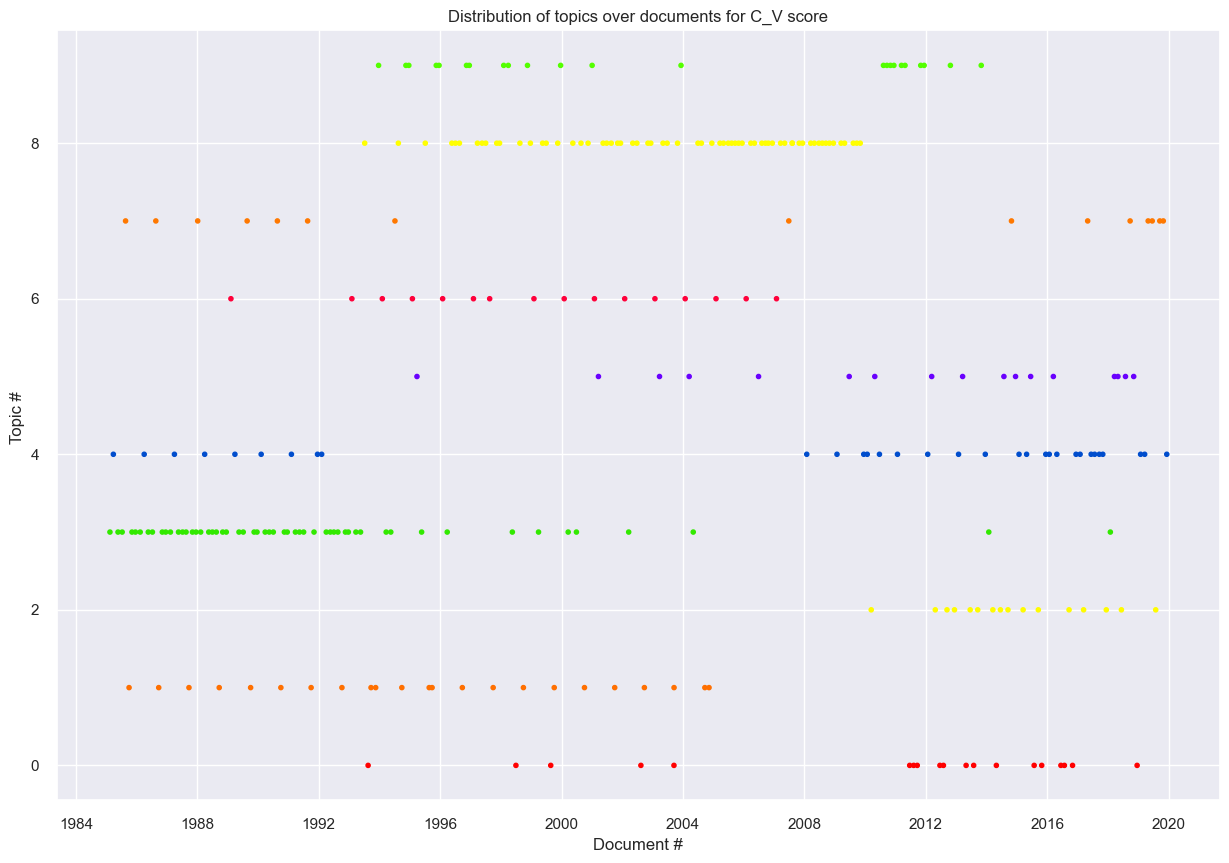

In [23]:
fig, ax =plt.subplots(1, figsize=(15, 10))
ax.scatter(y=topicmod.topic_mat, x=train_data.index, marker=".", c=topicmod.topic_mat, cmap="prism")
ax.set_xlabel("Document #")
ax.set_ylabel("Topic # ")
plt.title("Distribution of topics over documents for C_V score")
plt.show()

##### Topic Frequency across Documents {-}

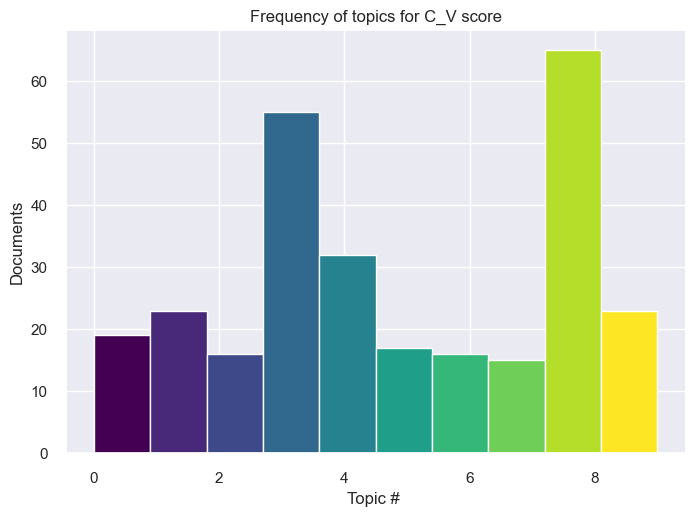

In [24]:
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(topicmod.topic_mat, bins=10)

# Use a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(patches)))

for i, patch in enumerate(patches):
    patch.set_facecolor(colors[i])
ax.set_ylabel("Documents")
ax.set_xlabel("Topic # ")
plt.title("Frequency of topics for C_V score")
plt.show()

##### Probability Distributions by Topic {-}

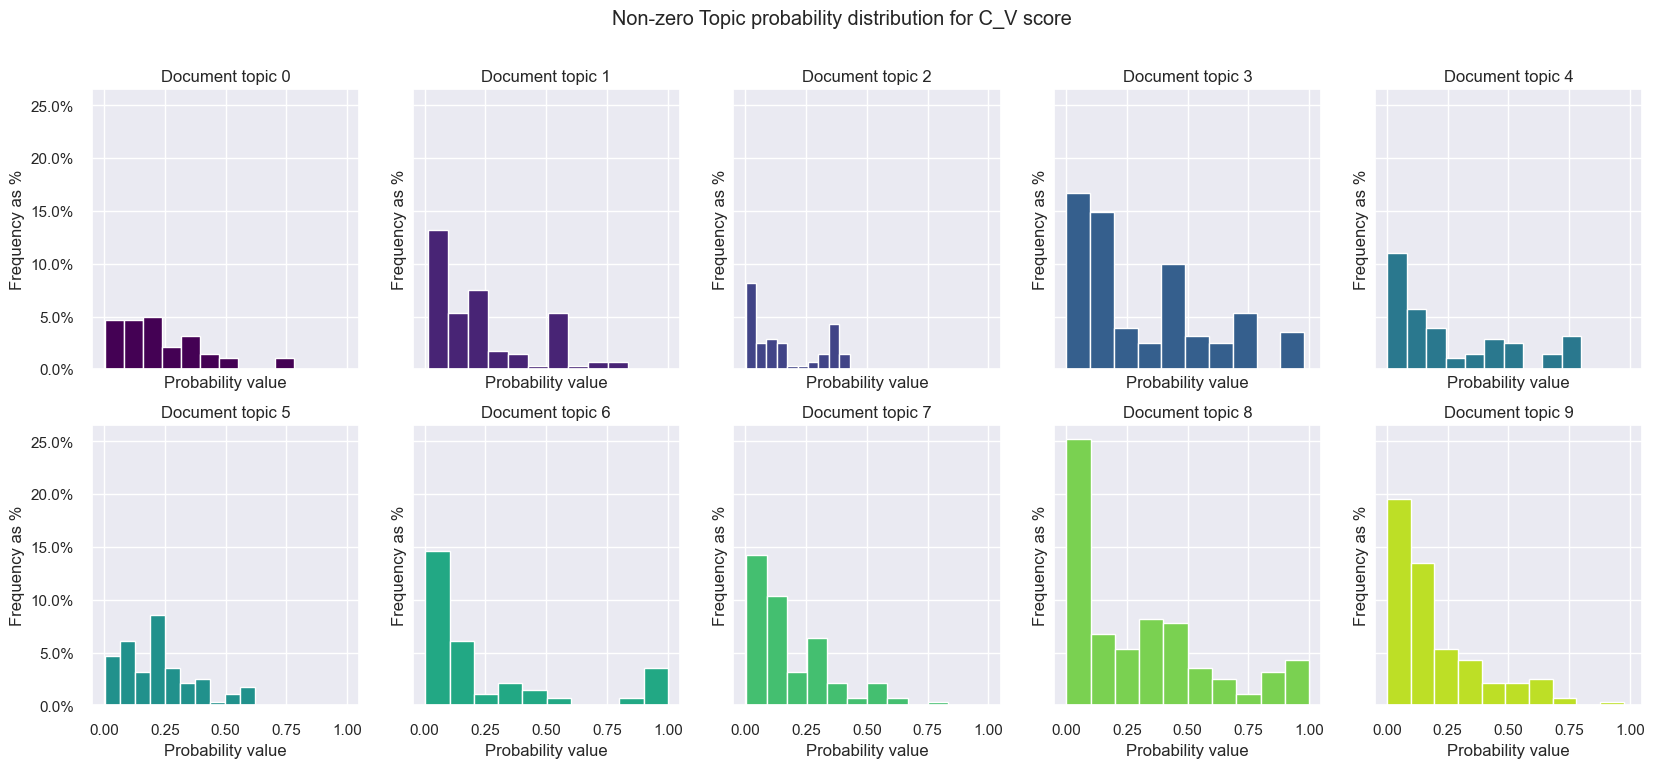

In [25]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8),sharey=True, sharex=True)
k = 0
cmap = cm.get_cmap('viridis')
for i in range(2):
    for j in range(5):
        df = topicmod.doc_mat[:, k][topicmod.doc_mat[:, k].nonzero()]
        ax[i, j].hist(df, weights= np.ones_like(df)/len(topicmod.doc_mat[:,k]), color=cmap(k/10))
        ax[i, j].set_title("Document topic " + str(k))
        ax[i, j].set_xlabel("Probability value")
        ax[i, j].set_ylabel("Frequency as %")
        k=k+1
        ax[i, j].yaxis.set_major_formatter(PercentFormatter(1))
plt.suptitle("Non-zero Topic probability distribution for C_V score")
plt.show()

##### LDA Visualization {-}

In [26]:
if LDA_IMPORT:
    topic_term_dists = topicmod.cv_model.get_topics()  # transpose to make shape (num_terms, num_topics)
    doc_topic_dists = topicmod.doc_mat # cv_model.get_document_topics(topicmod.tfidf_mat, minimum_probability=0)
    # doc_topic_dists = [[tup[1] for tup in lst] for lst in doc_topic_dists]  # convert list of tuples to just list
    doc_lengths = [len(doc) for doc in gensim_statements]
    vocab = list(dict_gensim_statements.token2id.keys())
    term_frequency = dict_gensim_statements.cfs
    
    # Use pyLDAvis
    vis_data = pyLDAvis.prepare(
        topic_term_dists=topic_term_dists,
        doc_topic_dists=doc_topic_dists,
        doc_lengths=doc_lengths,
        vocab=vocab,
        term_frequency=list(term_frequency.values())
    )
    
    print("Intertopic distance map for C_V Score\n\n")
    pyLDAvis.display(vis_data)
else:
    print(f"Please see attached PDF for LDA Visualization!")

Please see attached PDF for LDA Visualization!


#### Topic Modeling (UMass Scoring) {-}

In [27]:
um_topicmod = TopicModel(
    tfidf_class.tfidf_statements_train,
    tfidf_class.dict_gensim_statements,
    tfidf_class.X_train.apply(tokenizer_wo_stopwords).apply(lambda x: x.split(" ")).tolist(),
    cv_score="u_mass",
)

um_topicmod.fit()

##### Top 10 Words by Topic

In [28]:
um_topicmod.cv_model.show_topics(num_words=10)

[(0,
  '0.017*"foreign" + 0.014*"recent" + 0.014*"account" + 0.012*"taken" + 0.012*"reported" + 0.012*"markets" + 0.011*"actions" + 0.011*"developments" + 0.011*"period" + 0.010*"approved"'),
 (1,
  '0.012*"participants" + 0.012*"inflation" + 0.011*"rate" + 0.009*"s" + 0.009*"economic" + 0.008*"policy" + 0.007*"securities" + 0.007*"percent" + 0.005*"funds" + 0.005*"growth"')]

##### Topic Distribution by Time {-}

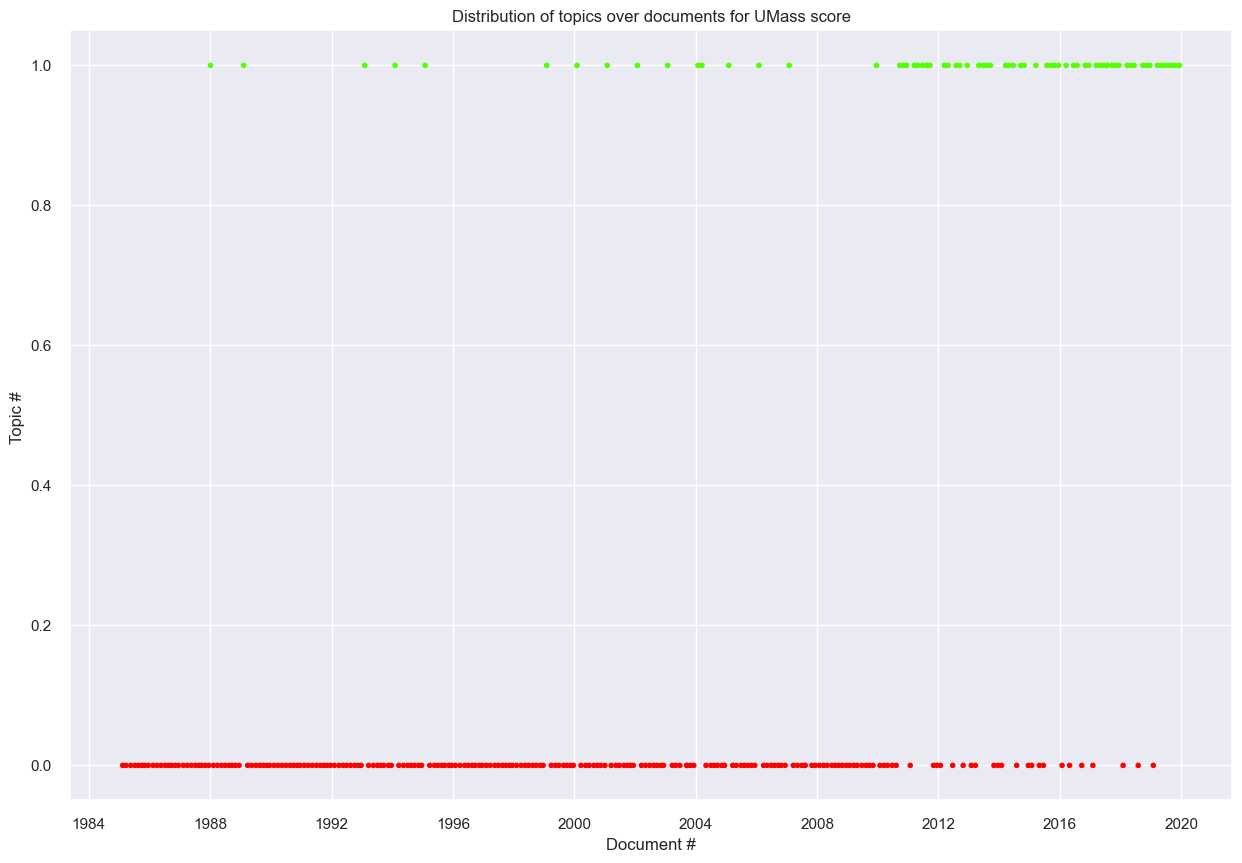

In [29]:
fig, ax =plt.subplots(1, figsize=(15, 10))
ax.scatter(y=um_topicmod.topic_mat, x=train_data.index, marker=".",c=um_topicmod.topic_mat, cmap="prism")
ax.set_xlabel("Document #")
ax.set_ylabel("Topic # ")
plt.title("Distribution of topics over documents for UMass score")
plt.show()

##### Topic Frequency across Documents {-}

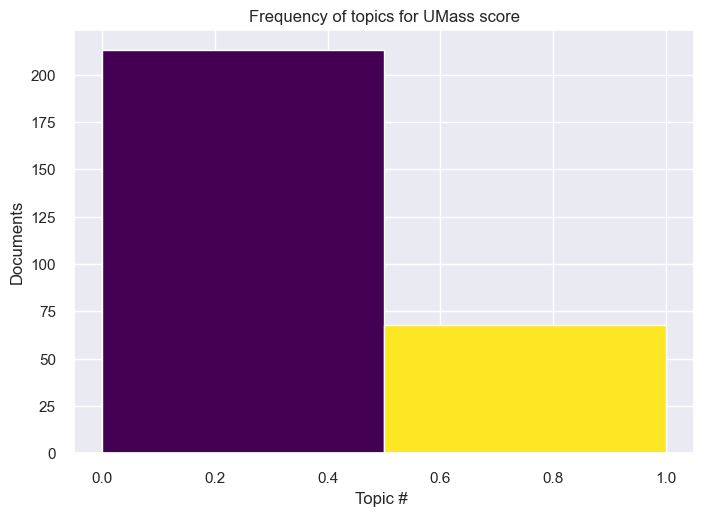

In [30]:
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(um_topicmod.topic_mat, bins=2)

# Use a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(patches)))

for i, patch in enumerate(patches):
    patch.set_facecolor(colors[i])
ax.set_ylabel("Documents")
ax.set_xlabel("Topic # ")
plt.title("Frequency of topics for UMass score")
plt.show()

##### Probability Distributions by Topic {-}

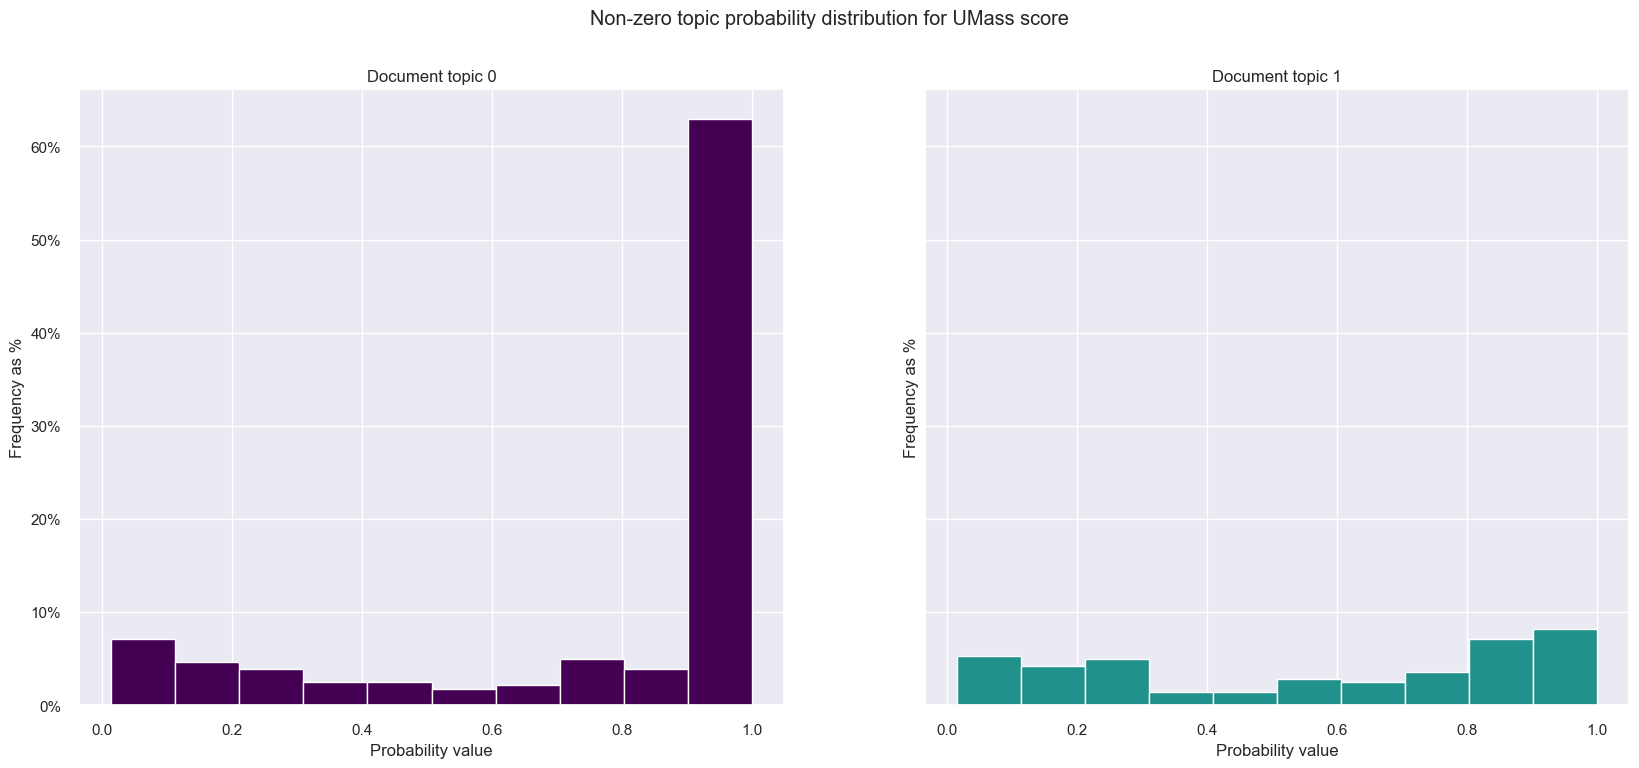

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), sharey=True, sharex=True)
cmap = cm.get_cmap('viridis')
k = 0
for j in range(2):
        df = um_topicmod.doc_mat[:, k][um_topicmod.doc_mat[:, k].nonzero()]
        ax[j].hist(df, weights= np.ones_like(df)/len(um_topicmod.doc_mat[:,k]), color=cmap(k/2))
        ax[j].set_title("Document topic " + str(k))
        ax[j].set_xlabel("Probability value")
        k=k+1
        ax[j].yaxis.set_major_formatter(PercentFormatter(1))
        ax[j].set_ylabel("Frequency as %")
plt.suptitle("Non-zero topic probability distribution for UMass score")
plt.show()

##### LDA Visualization {-}

In [32]:
if LDA_IMPORT:
    topic_term_dists = um_topicmod.cv_model.get_topics() # transpose to make shape (num_terms, num_topics)
    doc_topic_dists = um_topicmod.doc_mat # cv_model.get_document_topics(topicmod.tfidf_mat, minimum_probability=0)
    # doc_topic_dists = [[tup[1] for tup in lst] for lst in doc_topic_dists]  # convert list of tuples to just list
    doc_lengths = [len(doc) for doc in gensim_statements]
    vocab = list(dict_gensim_statements.token2id.keys())
    term_frequency = dict_gensim_statements.cfs
    
    # Use pyLDAvis
    vis_data = pyLDAvis.prepare(
        topic_term_dists=topic_term_dists,
        doc_topic_dists=doc_topic_dists,
        doc_lengths=doc_lengths,
        vocab=vocab,
        term_frequency=list(term_frequency.values())
    )
    print("Intertopic distance map for UMass score\n\n")
    pyLDAvis.display(vis_data)
else:
    print(f"Please see attached PDF for LDA Visualization!")

Please see attached PDF for LDA Visualization!


#### FinBERT Word Embeddings {-}

In [33]:
finbert = FinbertEmbedding()

In [34]:
def word_embedding_to_np(text: str):
    sentence_embedding = finbert.sentence_vector(text)
    res = np.array(list(map(lambda x: x.detach().numpy(), sentence_embedding)))
    return res

In [35]:
finbert_embeddings_train = train_data.text.apply(word_embedding_to_np)
finbert_embeddings_test = test_data.text.apply(word_embedding_to_np)

In [36]:
finbert_embeddings_train = pd.DataFrame(
    np.array(list(map(lambda x: list(x), finbert_embeddings_train.values))),
    columns=[f"Word {i}" for i in range(len(finbert_embeddings_train.values[0]))],
    index=train_data.index,
)

finbert_embeddings_test = pd.DataFrame(
    np.array(list(map(lambda x: list(x), finbert_embeddings_test.values))),
    columns=[f"Word {i}" for i in range(len(finbert_embeddings_test.values[0]))],
    index=test_data.index,
)

## Hidden Markov Models {-}

### Price Data - Reading {-}

In [37]:
epsilon = 0.5
theta = 0.01
trading_day = {'equity':12, 'fx':12,'bond':12}

In [38]:
df_ts = get_ts_data(
    '^GSPC',
    start_date=period_start,
    end_date=period_end,
    delta=trading_day['equity']
)

[*********************100%%**********************]  1 of 1 completed


### Price Data - Pre-Processing {-}

In [39]:
df_ts_train = df_ts[(df_ts.index.date >= train_start.date()) & (df_ts.index.date <= train_end.date())]
df_ts_test = df_ts[(df_ts.index.date >= test_start.date()) & (df_ts.index.date <= test_end.date())]

df_ts_train

Date
1985-01-02 00:00:00     165.369995
1985-01-02 12:00:00     167.199997
1985-01-03 00:00:00     164.570007
1985-01-03 12:00:00     165.369995
1985-01-04 00:00:00     163.679993
                          ...     
2019-12-27 12:00:00    3247.229980
2019-12-30 00:00:00    3221.290039
2019-12-30 12:00:00    3240.090088
2019-12-31 00:00:00    3230.780029
2019-12-31 12:00:00    3215.179932
Length: 17644, dtype: float64

In [40]:
def get_r_values(data):
    r_values = get_R(
        get_TMV(get_DC_data_v2(data, theta), theta),
        get_T(get_DC_data_v2(data, theta)),
        theta
    )
    return r_values

r_values_train = get_r_values(df_ts_train)
r_values_test = get_r_values(df_ts_test)

### Label Generation

In [41]:
hmm_regimes_train, hmm_model = fit_hmm(
    2,
    df_ts_train,
    r_values_train,
    '^GSPC',
    plot=False,
    verbose=False
)

hmm_regimes_test = hmm_model.predict(r_values_test.values.reshape(-1, 1))

In [42]:
hmm_regimes_train = pd.DataFrame.from_dict({
    'HMM_Regimes': list(hmm_regimes_train.values),
}).set_index(r_values_train.index)

hmm_regimes_test = pd.DataFrame.from_dict({
    'HMM_Regimes': hmm_regimes_test,
}).set_index(r_values_test.index)

In [43]:
display(hmm_regimes_train)

,HMM_Regimes
1985-01-02 12:00:00,0
1985-01-07 12:00:00,1
1985-01-10 00:00:00,0
1985-01-10 12:00:00,1
1985-01-14 00:00:00,0
...,...
2019-10-03 12:00:00,1
2019-10-04 00:00:00,0
2019-10-08 00:00:00,1
2019-11-27 00:00:00,0


# Supervised Learning {-}

## Fill Labels Across Entire Time Period

In [44]:
train_regimes = pd.DataFrame(index=pd.date_range(
    start=period_start,
    end=train_end + timedelta(1),
    freq='12H'
)[:-1])

train_regimes = pd.merge(
    left=train_regimes,
    right=nlp_regimes_train,
    how="left",
    left_index=True,
    right_index=True,
).bfill()

train_regimes = pd.merge(
    left=train_regimes,
    right=hmm_regimes_train,
    how="left",
    left_index=True,
    right_index=True,
).bfill()

train_regimes.NLP_Regimes = train_regimes.NLP_Regimes.ffill()
train_regimes.HMM_Regimes = train_regimes.HMM_Regimes.ffill()

train_regimes

,NLP_Regimes,HMM_Regimes
1985-01-01 00:00:00,1.0,0.0
1985-01-01 12:00:00,1.0,0.0
1985-01-02 00:00:00,1.0,0.0
1985-01-02 12:00:00,1.0,0.0
1985-01-03 00:00:00,1.0,1.0
...,...,...
2019-12-29 12:00:00,0.0,1.0
2019-12-30 00:00:00,0.0,1.0
2019-12-30 12:00:00,0.0,1.0
2019-12-31 00:00:00,0.0,1.0


## Equalize Indexes for Features

In [45]:
index_train = r_values_train.index
X_train = pd.DataFrame(index=index_train)

# ffill() topic model PDFs to account for dates on which we have text data but no DC data
topic_models_train_new = pd.merge(
    left=X_train,
    right=topic_models_train,
    how='outer',
    left_index=True,
    right_index=True
).ffill()
topic_models_train_new = topic_models_train_new[topic_models_train_new.index.isin(index_train)]

# ffill() word embeddings to account for dates on which we have text data but no DC data
finbert_embeddings_train_new = pd.merge(
    left=X_train,
    right=finbert_embeddings_train,
    how='outer',
    left_index=True,
    right_index=True
).ffill()
finbert_embeddings_train_new = finbert_embeddings_train_new[finbert_embeddings_train_new.index.isin(index_train)]

# Add name to R Values Series
r_values_train.name = 'R_Values_Train'

In [46]:
index_test = r_values_test.index
X_test = pd.DataFrame(index=index_test)

# ffill() topic model PDFs to account for dates on which we have text data but no DC data
topic_models_test_new = pd.merge(
    left=X_test,
    right=topic_models_test,
    how='outer',
    left_index=True,
    right_index=True
).ffill()
topic_models_test_new = topic_models_test_new[topic_models_test_new.index.isin(index_test)]

# ffill() word embeddings to account for dates on which we have text data but no DC data
finbert_embeddings_test_new = pd.merge(
    left=X_test,
    right=finbert_embeddings_test,
    how='outer',
    left_index=True,
    right_index=True
).ffill()
finbert_embeddings_test_new = finbert_embeddings_test_new[finbert_embeddings_test_new.index.isin(index_test)]

# Add name to R Values Series
r_values_test.name = 'R_Values_Test'

## Construct Covariates and Labels

In [47]:
# Flags to change covariates used in NB Classifier
USE_TOPIC_MODEL_PDF = True
USE_WORD_EMBEDDINGS = True
USE_R_VALUES = True

In [48]:
def make_X(
    train: bool = True,
    topic_model: bool = USE_TOPIC_MODEL_PDF,
    word_embeddings: bool = USE_WORD_EMBEDDINGS,
    price_data: bool = USE_R_VALUES,
):
    """
    This function creates a new DataFrame of covariates based on the flags which
    determine specifically which covariates will be included.

    @param train: flag for deciding if making train or test data
    @param topic_model: flag for including NMF Topic Models (loadings)
    @param word_embeddings: flag for including Finbert Word Embeddings
    @param topic_model: flag for including R Indicator Values (price data)
    @return X: pd.DataFrame indexed by DC Indicators containing specified covariates
    """
    if train:
        index = r_values_train.index
        topic_models_df = topic_models_train_new.copy()
        word_embeddings_df = finbert_embeddings_train_new.copy()
        r_values_df = r_values_train.copy()
    else:
        index = r_values_test.index
        topic_models_df = topic_models_test_new.copy()
        word_embeddings_df = finbert_embeddings_test_new.copy()
        r_values_df = r_values_test.copy()
    
    X = pd.DataFrame(index=index)
    
    # Add topic model PDFs to covariates DataFrame
    if topic_model:
        X = pd.merge(
            left=X,
            right=topic_models_df,
            how='inner',
            left_index=True,
            right_index=True
        )
    
    # Add word embeddings to covariates DataFrame
    if word_embeddings:
        X = pd.merge(
            left=X,
            right=word_embeddings_df,
            how='inner',
            left_index=True,
            right_index=True
        )
    
    # Add DC Indicator (price data) to covariates DataFrame
    if USE_R_VALUES:
        X = pd.merge(
            left=X,
            right=r_values_df,
            how='inner',
            left_index=True,
            right_index=True
        )
    
    # TODO: either bfill() here, or remove the NA rows from y_train and X_train
    X = X.bfill()

    if train:
        print(f"X_train: {X.shape}")
    else:
        print(f"X_test: {X.shape}")

    return X

In [49]:
def make_Y(
    train: bool = True,
):
    """
    This function constructs the NLP and HMM y-labels.

    @param train: flag for deciding if making train or test data
    @return (y_nlp, y_hmm): tuple containing NLP and HMM y-labels
    """
    if train:
        regimes = train_regimes.copy()
        index = index_train.copy()
    else:
        regimes = test_regimes.copy()
        index = index_test.copy()
    
    regimes = regimes[regimes.index.isin(index)]
    
    y_nlp = regimes.NLP_Regimes
    y_hmm = regimes.HMM_Regimes

    if train:
        print(f"y_train_nlp: {y_nlp.shape}")
        print(f"y_train_hmm: {y_hmm.shape}")
    else:
        print(f"y_test_nlp: {y_nlp.shape}")
        print(f"y_test_hmm: {y_hmm.shape}")
    
    return y_nlp, y_hmm

In [50]:
def make_data(
    topic_model: bool = USE_TOPIC_MODEL_PDF,
    word_embeddings: bool = USE_WORD_EMBEDDINGS,
    price_data: bool = USE_R_VALUES,
):
    """
    This function creates all X and y data for the classification model.

    @param topic_model: flag for including NMF Topic Models (loadings)
    @param word_embeddings: flag for including Finbert Word Embeddings
    @param topic_model: flag for including R Indicator Values (price data)
    @return (X_train, X_test, y_train_nlp, y_train_hmm, y_test_nlp, y_test_nlp): tuple containing all train and test data
    """
    X_train = make_X(
        train=True,
        topic_model=topic_model,
        word_embeddings=word_embeddings,
        price_data=price_data
    )
    X_test = make_X(
        train=False,
        topic_model=topic_model,
        word_embeddings=word_embeddings,
        price_data=price_data
    )
    y_train_nlp, y_train_hmm = make_Y(train=True)
    # y_test_nlp, y_test_hmm = make_Y(train=False)
    return X_train, X_test, y_train_nlp, y_train_hmm

In [51]:
X_train, X_test, y_train_nlp, y_train_hmm = make_data()

X_train: (4932, 779)
X_test: (563, 779)
y_train_nlp: (4932,)
y_train_hmm: (4932,)


# Classification and Performance on Trading Strategies

In [67]:
def make_test_regimes(X_train, X_test, do_all_func):
    test_regimes = pd.DataFrame(index=pd.date_range(
        start=test_start,
        end=period_end + timedelta(1),
        freq='12H'
    )[:-1])
    
    def add_to_regime_dataframe(X_train, y_train, X_test, label, test_regimes):
        y_pred = pd.DataFrame.from_dict({
            label: do_all_func(
                X_train.values,
                y_train.values,
                X_test.values,
            )
        }).set_index(index_test)
    
        test_regimes = pd.merge(
            left=test_regimes,
            right=y_pred,
            how="left",
            left_index=True,
            right_index=True,
        ).bfill()
    
        test_regimes[label] = test_regimes[label].ffill()
        return test_regimes
    
    test_regimes = add_to_regime_dataframe(
        X_train.iloc[:,-1:],
        pd.DataFrame(y_train_nlp),
        X_test.iloc[:,-1:],
        'Kmeans_labels_DC_indicators',
        test_regimes
    )
    test_regimes = add_to_regime_dataframe(
        X_train.iloc[:,:10],
        pd.DataFrame(y_train_nlp),
        X_test.iloc[:,:10],
        'Kmeans_labels_NMF_loadings',
        test_regimes
    )
    test_regimes = add_to_regime_dataframe(
        X_train.iloc[:,10:-1],
        pd.DataFrame(y_train_nlp),
        X_test.iloc[:,10:-1],
        'Kmeans_labels_finBERT_embeddings',
        test_regimes
    )
    test_regimes = add_to_regime_dataframe(
        X_train.iloc[:,-1:],
        pd.DataFrame(y_train_hmm),
        X_test.iloc[:,-1:],
        'HMM_labels_DC_indicators',
        test_regimes
    )
    test_regimes = add_to_regime_dataframe(
        X_train.iloc[:,:10],
        pd.DataFrame(y_train_hmm),
        X_test.iloc[:,:10],
        'HMM_labels_NMF_loadings',
        test_regimes
    )
    test_regimes = add_to_regime_dataframe(
        X_train.iloc[:,10:-1],
        pd.DataFrame(y_train_hmm),
        X_test.iloc[:,10:-1],
        'HMM_labels_finBERT_embeddings',
        test_regimes
    )

    return test_regimes

In [68]:
result_labels = [
    'Control 1',
    'Control 2',
    'K-means labels, only DC covariates',
    'K-means labels, NMF loading covariates',
    'K-means labels, FinBERT embeddings',
    'HMM labels, only DC covariates',
    'HMM labels, NMF loading covariates',
    'HMM labels, FinBERT embeddings'
]

def make_results(test_regimes):
    results = []
    
    strat_test = Pipeline(
        df_ts=df_ts,
        to_test=True,
        strat='control',
        start_date=str(train_start)[:10],
        train_end=str(train_end)[:10],
        test_start=str(test_start)[:10],
        theta=theta,
        epsilon=0.5,
        provide_labels=True,
        labels=test_regimes[test_regimes.columns[0]] # labels are a placeholder for control
    )
    strat_test.fit(verbose=False)
    results.append(strat_test.trading_metrics_test)
    
    strat_test = Pipeline(
        df_ts=df_ts,
        to_test=True,
        strat='control2',
        start_date=str(train_start)[:10],
        train_end=str(train_end)[:10],
        test_start=str(test_start)[:10],
        theta=theta,
        epsilon=0.5,
        provide_labels=True,
        labels=test_regimes[test_regimes.columns[0]]
    )
    strat_test.fit(verbose = False)
    results.append(strat_test.trading_metrics_test)
    
    for label, column in zip(result_labels[2:], test_regimes.columns):
        strat_test = Pipeline(
            df_ts=df_ts,
            to_test=True,
            start_date=str(train_start)[:10],
            train_end=str(train_end)[:10],
            test_start=str(test_start)[:10],
            theta=theta,
            epsilon=0.5,
            provide_labels=True,
            labels=test_regimes[column]
        )
        strat_test.fit(verbose = False)
        results.append(strat_test.trading_metrics_test)

    return results

In [69]:
do_all_map = {
    'nbc': do_all_NBC,
    'svm': do_all_SVM,
    'lr': do_all_LR,
}

def train_predict_eval(classifier):
    assert classifier in list(do_all_map.keys())
    do_all_func = do_all_map[classifier]
    test_regimes = make_test_regimes(X_train, X_test, do_all_func)
    results = make_results(test_regimes)
    results = pd.DataFrame(
        results,
        index=result_labels
    ).round(8).sort_values('sharpe')
    return test_regimes, results

## Naive Bayes Classifier

In [70]:
test_regimes_nbc, results_nbc = train_predict_eval('nbc')

In [71]:
results_nbc

,drawdown,profit,sharpe
"K-means labels, NMF loading covariates",0.154341,0.530849,0.540878
Control 1,0.154341,0.530849,0.541172
"K-means labels, only DC covariates",0.154341,0.530849,0.541172
"K-means labels, FinBERT embeddings",0.154341,0.530849,0.541172
"HMM labels, FinBERT embeddings",0.154341,0.530849,0.541172
Control 2,0.154564,0.529506,0.616659
"HMM labels, NMF loading covariates",0.158274,0.530849,0.618412
"HMM labels, only DC covariates",0.222633,0.901848,0.710041


## SVM Classifier

In [72]:
test_regimes_svm, results_svm = train_predict_eval('svm')

In [73]:
results_svm

,drawdown,profit,sharpe
"HMM labels, FinBERT embeddings",0.220305,0.502490,0.519751
"K-means labels, FinBERT embeddings",0.154341,0.502490,0.524675
Control 1,0.154341,0.530849,0.541172
"K-means labels, only DC covariates",0.154341,0.530849,0.541172
"K-means labels, NMF loading covariates",0.154341,0.511204,0.548407
"HMM labels, NMF loading covariates",0.220305,0.511204,0.568708
Control 2,0.154564,0.529506,0.616659
"HMM labels, only DC covariates",0.222633,0.901848,0.710041


## Logistic Regression Classifier

In [74]:
test_regimes_lr, results_lr = train_predict_eval('lr')

In [75]:
results_lr

,drawdown,profit,sharpe
"K-means labels, FinBERT embeddings",0.154341,0.509879,0.535931
Control 1,0.154341,0.530849,0.541172
"K-means labels, only DC covariates",0.154341,0.530849,0.541172
"K-means labels, NMF loading covariates",0.154341,0.530849,0.541172
"HMM labels, FinBERT embeddings",0.158381,0.520688,0.541302
"HMM labels, NMF loading covariates",0.158274,0.522022,0.612402
Control 2,0.154564,0.529506,0.616659
"HMM labels, only DC covariates",0.222633,0.901848,0.710041


## Stuff

In [204]:
test_regimes_nbc_plot = test_regimes_nbc[pd.DatetimeIndex(test_regimes_nbc.index.date).isin(test_data.index)]
test_regimes_nbc_plot

,Kmeans_labels_DC_indicators,Kmeans_labels_NMF_loadings,Kmeans_labels_finBERT_embeddings,HMM_labels_DC_indicators,HMM_labels_NMF_loadings,HMM_labels_finBERT_embeddings
2020-01-29 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-29 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-15 00:00:00,0.0,0.0,0.0,1.0,1.0,0.0
2020-03-15 12:00:00,0.0,0.0,0.0,1.0,1.0,0.0
2020-04-29 00:00:00,0.0,0.0,0.0,0.0,1.0,0.0
2020-04-29 12:00:00,0.0,0.0,0.0,1.0,1.0,0.0
2020-06-10 00:00:00,0.0,0.0,0.0,1.0,0.0,0.0
2020-06-10 12:00:00,0.0,0.0,0.0,1.0,0.0,0.0
2020-07-29 00:00:00,0.0,0.0,0.0,0.0,1.0,0.0
2020-07-29 12:00:00,0.0,0.0,0.0,0.0,1.0,0.0


In [234]:
label_list = []
column_list = []
date_list = []
test_regimes = test_regimes_nbc_plot

for i, col in enumerate(test_regimes.columns):
    col_vals = test_regimes.loc[:, test_regimes.columns[i]]
    label_list += list(col_vals.values)
    column_list += [col for _ in range(col_vals.shape[0])]
    date_list += list(test_regimes.index.date)

df = pd.DataFrame.from_dict({
    'LABEL': label_list,
    'COLUMN': column_list,
    'DATE': date_list,
}).sort_values(by='DATE')

df['LABEL'] = df['LABEL'].astype("int").astype("category")
df.DATE = pd.to_datetime(df.DATE)
df = df.drop_duplicates(subset=('COLUMN', 'DATE'))

df.reset_index(inplace=True)
df['x'] = df.index.astype("int")

df

,index,LABEL,COLUMN,DATE,x
0,0,0,Kmeans_labels_DC_indicators,2020-01-29,0
1,112,0,Kmeans_labels_finBERT_embeddings,2020-01-29,1
2,57,0,Kmeans_labels_NMF_loadings,2020-01-29,2
3,281,0,HMM_labels_finBERT_embeddings,2020-01-29,3
4,169,0,HMM_labels_DC_indicators,2020-01-29,4
...,...,...,...,...,...
163,278,0,HMM_labels_NMF_loadings,2023-06-14,163
164,223,0,HMM_labels_DC_indicators,2023-06-14,164
165,334,0,HMM_labels_finBERT_embeddings,2023-06-14,165
166,111,0,Kmeans_labels_NMF_loadings,2023-06-14,166


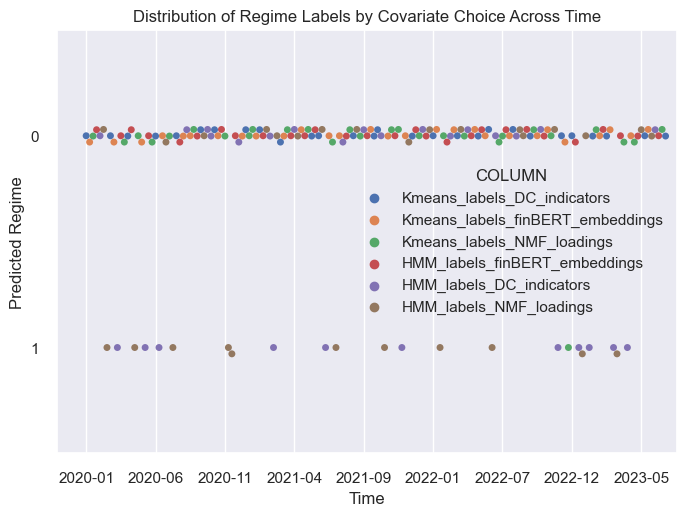

In [246]:
ax = sns.swarmplot(
    data=df.drop_duplicates(subset=('COLUMN', 'DATE')),
    x="x",
    y="LABEL",
    hue="COLUMN"
)

labels = ax.get_xticklabels()

def get_date(label):
    txt = str(label)
    if '−' in txt or '-' in txt:
        return txt
    txt = int(txt)
    if txt > max(df.x.astype("int")):
        return str(txt)
    my_date = pd.to_datetime(df[df.x == txt].DATE.values[0]).date()
    return f"{my_date.year}-{'0' + str(my_date.month) if my_date.month < 10 else my_date.month}"

ax.set_xticklabels(list(map(get_date, [-20] + [i * 20 for i in range(9)])))

xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[1] - 5)

ax.set_xlabel('Time')
ax.set_ylabel('Predicted Regime')
ax.set_title('Distribution of Regime Labels by Covariate Choice Across Time')

plt.show()

[Text(-25.0, 0, '−25'), Text(0.0, 0, '0'), Text(25.0, 0, '25'), Text(50.0, 0, '50'), Text(75.0, 0, '75'), Text(100.0, 0, '100'), Text(125.0, 0, '125'), Text(150.0, 0, '150'), Text(175.0, 0, '175'), Text(200.0, 0, '200')]
0
25
50
75
100
125
150


['−25',
 '2020-01-29',
 '2020-07-29',
 '2021-01-27',
 '2021-07-28',
 '2022-01-26',
 '2022-07-27',
 '2023-03-22',
 '175',
 '200']

In [203]:
df[df.x == 100]

,LABEL,COLUMN,DATE,x
100,0,Kmeans_labels_NMF_loadings,2022-11-02,100
